# Convolutional Neural Networks

CNNs are a twist on the neural network concept designed specifically to process data with spatial relationships. In the deep neural networks we've seen so far every node is always connected to every other node in the subsequent layer. While spatial relationships CAN be captured, as we've seen with out results on MNIST, the networks were not explicitly built with the assumption that spatial relationships definitely exist. Artificial neural networks are perfectly appropriate for data where the relationships are not spatial. 

But, for data such as images, it seems crazy to ignore the spatial relationships! For the vast majority of image data, neighboring pixels combined with each other tell us much more than combining the pixels in opposite corners or the image. CNN's rely on the assumption that our data has spatial relationships, and they have produced state-of-the-art results especially in image processing and computer vision. 

The fundamental unit of a CNN is a "convolution":

![](img/convolution.png)

> Image Source: https://github.com/PetarV-/TikZ/tree/master/2D%20Convolution

The key component of the convolution is called the kernel, which is a matrix. K in the image above. The kernel has a shape, 3x3 in this example, but we can define the for each convolution. We "slide" the kernel across every 3x3 section of the image performing item-by-item multiplication, for example in the above image the 4 highlighted in green is produced by taking the values highlighted in red, multiplying the values in the same position in the kernel, and summing the result of those multiplications. Specifically:


```
position:  [0,0]   [0,1]   [0,2]     [1,0]   [1,1]   [1,2]     [2,0]   [2,1]   [2,2]
operation: (1*1) + (0*0) + (0*1)  +  (1*0) + (1*1) + (0*0)  +  (1*1) + (1*0) + (1*1) == 4
```

This value is (optionally, but typically) then passed through a non-linearity like ReLU or Sigmoid before it is passed to the next layer. 

> Side note: In the literature, you'll discover that in a "true" convolution the kernel is inverted prior to the multiply+sum operation, and that this operation without the inversion is actually called "cross correlation" by most mathematicians. This matters in some contexts but we typically ignore it in deep learning because the values of the kernel are the things that are fine tuned, and storing them as "pre-inverted" matrixes is computationally efficent compared to inverting the kernel repeatedly. 

Here is a helpful animation to visualize convolutions:

![](img/animated-conv.gif)

> Image source: https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d

A convolutional layer has a few important properties:

* **Number of kernels** -- this is similar to the number of nodes in an ANN
    * Each kernel will be separately trained on the input data. 
    * Each kernel will produce an output layer, sometimes called a feature map.
    * These feature maps are used as input to the next layer.
* **Kernel size** -- these are almost always 3x3 or 5x5. 
    * Bigger kernels are more computationally expensive.
    * Bigger kernals have a wider "field of view" which can be helpful.
    * Dialted convolutions can capture a wider field of view at a lower computational cost (see additional resources).
* **Padding** -- notice above that a convolution produces a smaller output layer than the input layer by 1 pixel in each direction. Padding the input (typically with 0 values) allows the convolution to produce an output with the same size as the input. 
    * Downsampling to smaller sizes isn't always bad.
    * It reduces the computational costs at the next layer. 
    * If we don't pad, it limits the possible depth of the network esp. for small inputs
    * Padding tends to preserve information at the borders. If your images have important features on the edges, padding can improve performance
* **Stride** -- in the above we "slide" the kernel over by 1 pixel at every step. Increasing the stride increases the amount we slide by. 
    * Stride is typically set to 1. 
    * Higher values reduce the amount of information captured.
    * Higher values are more computationally efficent, as fewer values are combined per convolution.

One last important concept before we build a CNN: pooling. Pooling is a tactic used to decrease the resolution of our feature maps, and it is largely an issue of computational efficency. There are 2 popular kinds, max pooling and average pooling. Pooling layers use a window size, say 2x2, and take either the max or average value within each window to produce the output layer. The windows are almost always square, and the stride size is almost always set to the size of the window:

![](img/maxpool.jpeg)

> Image source: https://cs231n.github.io/convolutional-networks/

It is worth noting that pooling has fallen out of favor in a lot of modern architectures. Many machine learning practitioners have started downsampling through convolutions with larger stride sizes instead of pooling. 

### Building Our First CNN

Let's use Keras to build a CNN now.

In [1]:
# Setting up MNST, this should look familiar:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from keras.utils import to_categorical

# For examining results
from sklearn.metrics import confusion_matrix
import seaborn as sn

num_classes = 10 
image_size = 784

(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()
training_data = training_images.reshape(training_images.shape[0], image_size) 
test_data = test_images.reshape(test_images.shape[0], image_size)

training_labels = to_categorical(training_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

Using TensorFlow backend.


In [2]:
conv_training_data = training_images.reshape(60000, 28, 28, 1)
conv_test_data = test_images.reshape(10000, 28, 28, 1)

In [3]:
def plot_training_history(history, model, eval_images=False):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()
    
    if eval_images:
        loss, accuracy  = model.evaluate(conv_test_data, test_labels, verbose=False)
    else:
        loss, accuracy  = model.evaluate(test_data, test_labels, verbose=False)
        
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

This time, we're using a new dataset called "Fashion MNIST". Like the handwritten digits dataset, this is a set of grayscale images each 28 by 28 pixels. However, the subject of these images is very different from the handwritten digits dataset. Instead, these are images of fashion objects. Let's take a look at some:

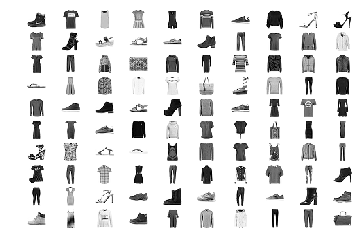

In [4]:
# Lets visualize the first 100 images from the dataset
for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    ax.axis('off')
    plt.imshow(training_images[i], cmap='Greys')

In [5]:
i = 0 # So we can look at one at a time...

# So we can see the label
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

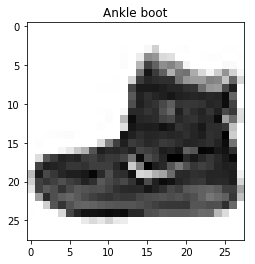

In [6]:
label = np.argmax(training_labels[i])
plt.title(label_map[label])
plt.imshow(training_images[i], cmap='Greys')
i += 1

Once again, there are 10 classes of image:

0 	T-shirt/top  
1 	Trouser  
2 	Pullover  
3 	Dress  
4 	Coat  
5 	Sandal  
6 	Shirt  
7 	Sneaker  
8 	Bag  
9 	Ankle boot  

As you might guess, this is a bigger challenge than the handwritten digits. Firstly, at 28 by 28 pixels much more fidelity is lost in this dataset compared to the digits dataset. Secondly, more pixels matter. In the digits dataset, we rarely care about the weight of the pixel, more or less what matters is if it's white or something else—we mostly cared about the edges between where someone had drawn and where they had not. Now internal differences in grayscale intensity are more informative, and comprise a larger amount of the image.

Let's quickly verify that a standard ANN that worked well in the context of MNIST fails in Fashion MNIST:

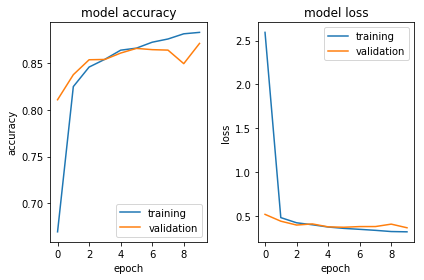

Test loss: 0.395
Test accuracy: 0.861


In [19]:
# Recall from the Optimizers section that we were able to get 97+ test accuracy with this network:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(image_size,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

# nadam performed best, as did categorical cross entropy in our previous experiments...
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_data, training_labels, batch_size=128, epochs=10, verbose=False, validation_split=.1)
plot_training_history(history, model)

Not bad, but not nearly as good as we were able to achieve with regular MNIST. Plus some overfitting concerns are showing themselves in the chart...

In [8]:
# The model is still sequentail, nothing new here.
model = Sequential()

# add model layers. The first parameter is the number of filters to make at each layer.
# Meaning here the result of the first layer is 64 different "feature maps" or "activation maps"
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# Lets fit it with identical parameters and see what happens...
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 128s 2ms/step - loss: 0.8630 - acc: 0.8262 - val_loss: 0.3524 - val_acc: 0.8753
Epoch 2/3
54000/54000 [==============================] - 127s 2ms/step - loss: 0.2822 - acc: 0.8979 - val_loss: 0.3259 - val_acc: 0.8827
Epoch 3/3
54000/54000 [==============================] - 126s 2ms/step - loss: 0.2329 - acc: 0.9161 - val_loss: 0.3281 - val_acc: 0.8912


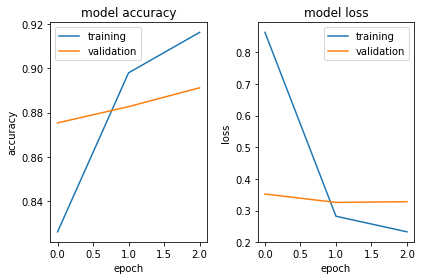

Test loss: 0.346
Test accuracy: 0.885


In [11]:
# OOPS! Previously, we flattened our training data, but now we INTEND on having 2D input data.
# training_data => 784 long vector
# training_images => 28 x 28 matrix
# Plus one small caveat: we have to indicate the number of color channels explicitly as a dimension...
history = model.fit(conv_training_data, training_labels, batch_size=128, epochs=3, verbose=True, validation_split=.1)
plot_training_history(history, model, eval_images=True)

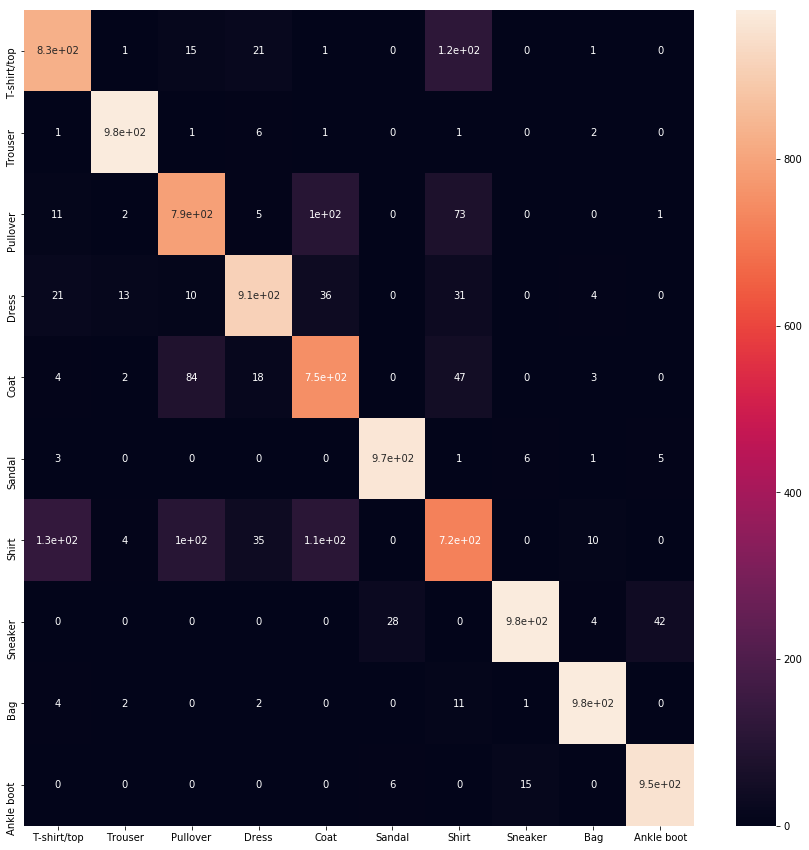

In [12]:
# When did our evaluator do poorly?
predictions = model.predict(conv_test_data)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels, axis=1))
plt.figure(figsize = (15, 15))

name_labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 44s 821us/step - loss: 6.4908 - acc: 0.5327 - val_loss: 0.3787 - val_acc: 0.8622
Epoch 2/5
54000/54000 [==============================] - 45s 825us/step - loss: 0.3446 - acc: 0.8736 - val_loss: 0.3144 - val_acc: 0.8837
Epoch 3/5
54000/54000 [==============================] - 42s 772us/step - loss: 0.2812 - acc: 0.8957 - val_loss: 0.2853 - val_acc: 0.8922
Epoch 4/5
54000/54000 [==============================] - 41s 761us/step - loss: 0.2454 - acc: 0.9077 - val_loss: 0.3134 - val_acc: 0.8937
Epoch 5/5
54000/54000 [==============================] - 41s 753us/step - loss: 0.2202 - acc: 0.9167 - val_loss: 0.2864 - val_acc: 0.8995


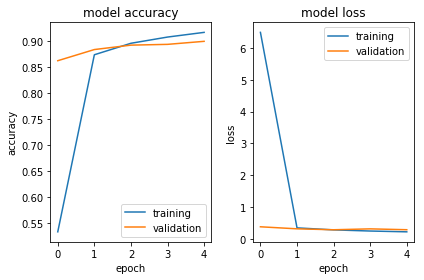

Test loss: 0.284
Test accuracy: 0.898


In [17]:
# Lets make a few small changes and see what happens...
model = Sequential()

# Note, fewer filters and a bigger kernel, plus a pooling layer
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Note, more filters and a pooling
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2 dense layers with dropout before the final.
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(conv_training_data, training_labels, batch_size=128, epochs=5, verbose=True, validation_split=.1)

plot_training_history(history, model, eval_images=True)

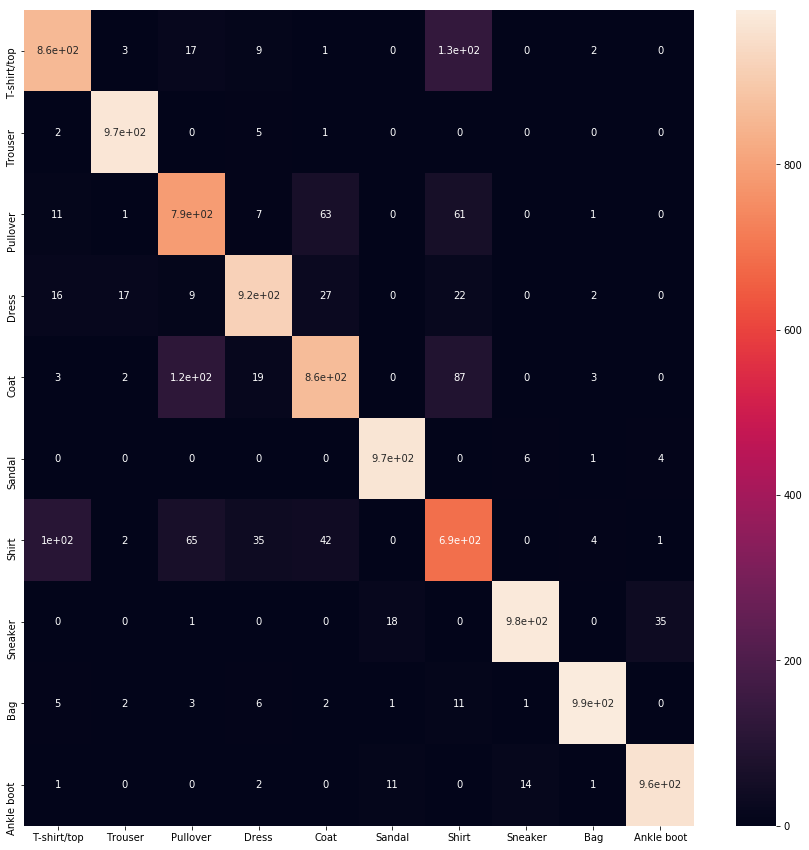

In [18]:
predictions = model.predict(conv_test_data)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels, axis=1))
plt.figure(figsize = (15, 15))

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()

90% is pretty respectible, especially considering how speedy training was, and given that we didn't apply any data augmentation. [Some state of the art networks get around 93-95% accuracy](https://github.com/zalandoresearch/fashion-mnist). It's also worth noting that we only really fail on comparing pullovers to coats, and tops to t-shirts.

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 13s 239us/step - loss: 0.9870 - acc: 0.8106 - val_loss: 0.3624 - val_acc: 0.8663
Epoch 2/5
54000/54000 [==============================] - 12s 218us/step - loss: 0.2995 - acc: 0.8897 - val_loss: 0.3104 - val_acc: 0.8850
Epoch 3/5
54000/54000 [==============================] - 12s 227us/step - loss: 0.2406 - acc: 0.9107 - val_loss: 0.2913 - val_acc: 0.8928
Epoch 4/5
54000/54000 [==============================] - 12s 231us/step - loss: 0.2022 - acc: 0.9247 - val_loss: 0.3373 - val_acc: 0.8800
Epoch 5/5
54000/54000 [==============================] - 12s 227us/step - loss: 0.1788 - acc: 0.9333 - val_loss: 0.3214 - val_acc: 0.8903


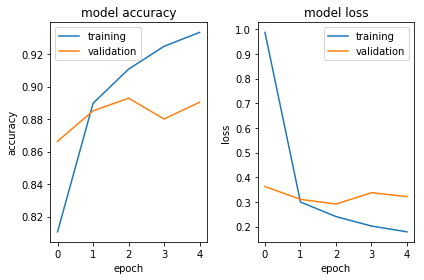

Test loss: 0.347
Test accuracy: 0.888


In [22]:
# Lets get rid of pooling and try using striding to do the downsampling instead.
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(2,2), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(conv_training_data, training_labels, batch_size=128, epochs=5, verbose=True, validation_split=.1)

plot_training_history(history, model, eval_images=True)

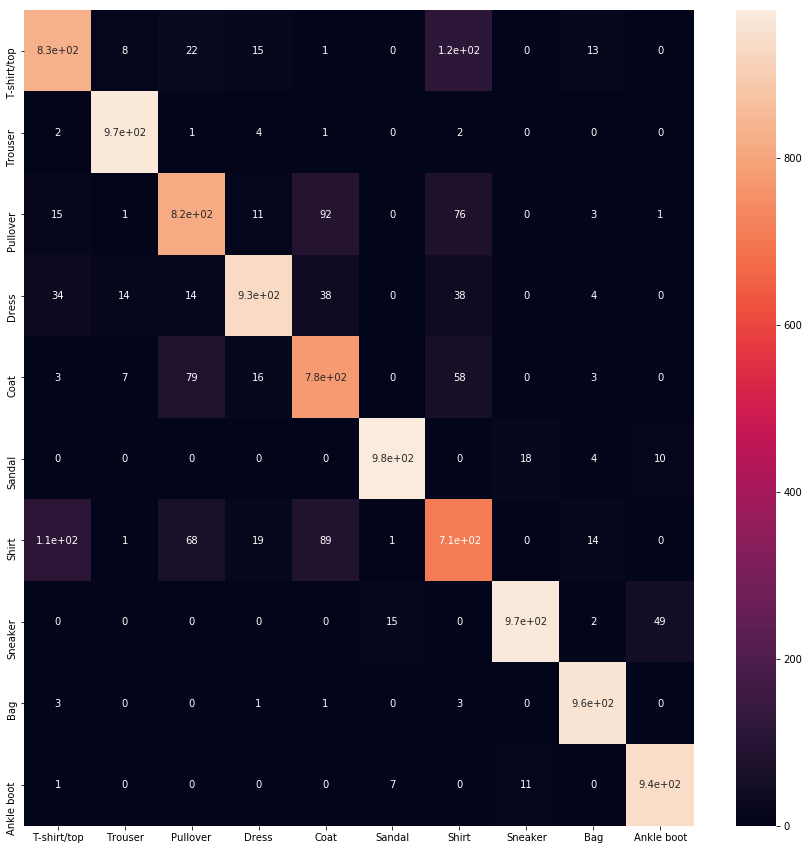

In [23]:
predictions = model.predict(conv_test_data)
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels, axis=1))
plt.figure(figsize = (15, 15))

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.show()

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 28s 524us/step - loss: 1.0724 - acc: 0.8048 - val_loss: 0.3270 - val_acc: 0.8807
Epoch 2/5
54000/54000 [==============================] - 28s 510us/step - loss: 0.2970 - acc: 0.8937 - val_loss: 0.3001 - val_acc: 0.8927
Epoch 3/5
54000/54000 [==============================] - 27s 508us/step - loss: 0.2396 - acc: 0.9114 - val_loss: 0.3013 - val_acc: 0.8913
Epoch 4/5
54000/54000 [==============================] - 27s 494us/step - loss: 0.2065 - acc: 0.9230 - val_loss: 0.2988 - val_acc: 0.8990
Epoch 5/5
54000/54000 [==============================] - 27s 500us/step - loss: 0.1832 - acc: 0.9309 - val_loss: 0.2945 - val_acc: 0.8985


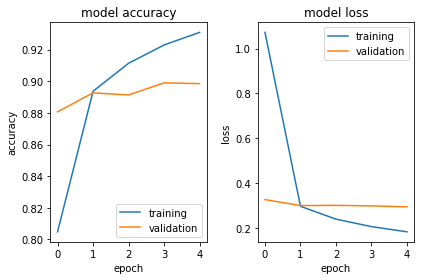

Test loss: 0.325
Test accuracy: 0.894


In [28]:
# Sweet, faster and similar performance, looks a bit at risk for overfitting.
# Lets try one more:
model = Sequential()

# Downsample on the first layer via strides.
model.add(Conv2D(32, kernel_size=(5, 5), strides=(2,2), activation='relu', padding='same', input_shape=(28,28,1)))

# Once downsampled, don't down sample further (strides back to (1,1))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(Flatten())

# NOTE, because we're downsampling much less I reduced the number of nodes in this layer.
# keeping it at 256 explodes the total parameter count and slows down learning a lot.
model.add(Dense(64, activation='relu')) 
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(conv_training_data, training_labels, batch_size=128, epochs=5, verbose=True, validation_split=.1)

plot_training_history(history, model, eval_images=True)

In [ ]:
# Pretty similar results. This would be a good place to apply data augmentation or collect a bit more data. 
# We could continue to experiment with different models and probably find some small improvements as well. 
# Plus, these models might all improve some if we kept training. They are overfitting a bit, but validation
# Scores are still rising by the end. 